In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import SimpleRNN
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer

from keras.preprocessing import sequence
from keras.preprocessing.sequence import  pad_sequences
from keras.datasets import imdb

from konlpy.tag import Okt
import statsmodels.api as sm
%matplotlib inline

Using TensorFlow backend.


# RNN 

In [2]:
model = Sequential()
model.add(SimpleRNN(3, input_shape=(2,10)))   #   input_lengtg는 입력 시컨스의 길이
# model.add(SimpleRNN(3, input_length=2, input_dim=10))와 동일함.
model.summary()
# 크기는 hidden 갯수와 dim에 의해 결정됨
# wx = 3 *  10  = 30      입력에서 hidden으로   
# wh = 3 * 3    = 9       출력이 hidden*hidden이므로   
# b = 3         = 3              -> 42개   # 출력층의 hidden

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 3)                 42        
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________


# RNN을 이용한 시계열 데이터 분석 예

In [3]:
step = 4
#데이터를 가상적으로 1000개를 만든다.
N = 1000    
Tp = 800    

t=np.arange(0,N)
x=np.sin(0.02*t)+2*np.random.rand(N)
df = pd.DataFrame(x)

values=df.values
train,test = values[0:Tp,:], values[Tp:N,:]   # 800, 200개로 분할

#여기에는 y값이 별도로 존재하지 않는다.
print(train.shape)
print(test.shape)

(800, 1)
(200, 1)


In [4]:
seq = [1,2,3,4,5,6,7]
sp = 3

seq = [1,2,3,4,5,6,7,7,7,7]
#  시퀀스 데이터를 주어야 한다.
#  입력신호가 3개의 seq 길이를 갖도록 학습 데이터 seq 생성
#                                        입력        출력
#  1,2,3,4,5,6,7,0,0,0                 [1,2,3]       [4] 
#                                      [2,3,4]       [5]
#                                      [3,4,5]       [6]
#                                      [4,5,6]       [7]
#                                      [5,6,7]       [7]
#                                      [6,7,7]       [7] 
#                                      [7,7,7]       [7] 

In [5]:
#repeat 함수 : 반복함수
#-1 : 마지막 원소를 step만큼 반복해라
#예를들어 위의 리스트를 보자면, step이 3이니, 7을 세번 반복

train = np.append(train,np.repeat(train[-1,],step))  # 마지막값을 step만큼 반복
test = np.append(test,np.repeat(test[-1,],step))

In [6]:
print(train.shape)
print(test.shape)

(804,)
(204,)


In [7]:
print(train[:10])
print(train[798:])

[0.06823315 1.9811112  1.81933701 0.19449547 1.54901417 0.45649039
 1.90630105 0.76680107 0.63460003 0.85264013]
[ 0.55881815 -0.26599929 -0.26599929 -0.26599929 -0.26599929 -0.26599929]


In [8]:
#위의 시퀀스가 주어졌을때, 길이가 3인 입력과 길이가 1인 출력이 나오도록 정의한 함수 
def convertToMatrix(data, step):
 X, Y =[], []
 for i in range(len(data)-step):
  # d는 3이된다.
  d=i+step  
  X.append(data[i:d,])
  Y.append(data[d,])
 return np.array(X), np.array(Y)

trainX,trainY =convertToMatrix(train,step)
testX,testY =convertToMatrix(test,step)

print(trainX.shape)
print(trainY.shape)

(800, 4)
(800,)


In [9]:
print(train[:10])
print(trainX[0])
print(trainX[1])
print(trainY[0])
print(trainY[1])

[0.06823315 1.9811112  1.81933701 0.19449547 1.54901417 0.45649039
 1.90630105 0.76680107 0.63460003 0.85264013]
[0.06823315 1.9811112  1.81933701 0.19449547]
[1.9811112  1.81933701 0.19449547 1.54901417]
1.549014166025681
0.45649038749589316


In [10]:
#3차원 shape으로 구성
#3차원 shape를 요구하기에
#reshape을 한것이다. 달라진것은 없다.
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)

(800, 1, 4)


In [11]:
model = Sequential()
#히든레이어가 32개
model.add(SimpleRNN(units=32, input_shape=(1,step), activation="tanh"))
#시그모이드나 Relu를 써도 된다.
model.add(Dense(8, activation="tanh")) 
model.add(Dense(1))
#loss로 mean square 에러 사용
model.compile(loss='mse', optimizer='adam')
model.fit(trainX,trainY, epochs=100, batch_size=16, verbose=0)

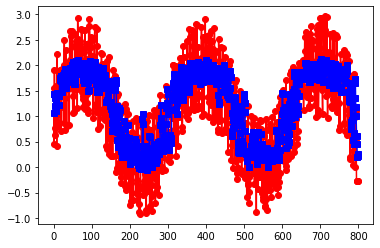

In [12]:
#빨간색 : 원본 데이터, 파란색 : 학습된 데이터
plt.plot(trainY, 'ro-', label="target")
plt.plot(model.predict(trainX), 'bs-', label="output")

(-3, 3)

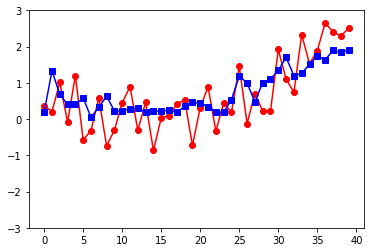

In [13]:
plt.plot(testY[0::5], 'ro-', label="target")
plt.plot(model.predict(testX[0::5]), 'bs-', label="output") #0부터 끝까지 5씩 증가
plt.ylim([-3,3])

 # "영국의 호흡기 질환으로 인한 사망자 수" 시계열 데이터분석

In [14]:
data = sm.datasets.get_rdataset("deaths", "MASS")
df = data.data
df.tail()

,time,value
67,1979.583333,1354
68,1979.666667,1333
69,1979.750000,1492
70,1979.833333,1781
71,1979.916667,1915


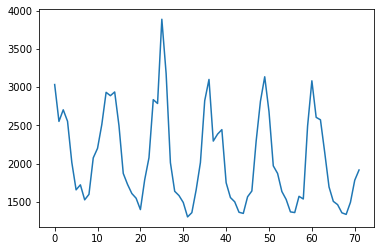

In [15]:
df.value.plot()
plt.show()

In [16]:
df["cliped_value"] = df.value.clip_upper(2000)
df.cliped_value.plot()
plt.show()

AttributeError: 'Series' object has no attribute 'clip_upper'

In [17]:
print(df.cliped_value)
print(df.cliped_value.values)

AttributeError: 'DataFrame' object has no attribute 'cliped_value'

In [18]:
seq = [1,2,3,4,5,6,7]
ts = 3;

#  3개의 seq 길이를 갖도록 학습 데이터 생성,   y값은 ts 다음값(즉 4번째 부터 가져옴)
#  1,2,3,4,5,6,7,8,9                   [1,2,3]      [4] 
#                                      [2,3,4]     [5]      
x = np.array([np.array([seq[i+j] for j in range(ts)])  
                      for i in range(len(seq) - ts)]).reshape(-1,ts,1)   
y = seq[ts:]

print(x.shape)
print(x)
print(y)

(4, 3, 1)
[[[1]
  [2]
  [3]]

 [[2]
  [3]
  [4]]

 [[3]
  [4]
  [5]]

 [[4]
  [5]
  [6]]]
[4, 5, 6, 7]


In [19]:
ts = 7

df["cliped_std_value"] = df.cliped_value.map(lambda x : (x - df.cliped_value.mean()) / np.std(df.cliped_value))
#df["cliped_std_value"] = df.cliped_value
X_train = np.array([np.array([df.cliped_std_value.values[i+j] for j in range(ts)])  # ts만큼 만복
                      for i in range(len(df.cliped_std_value) - ts)]).reshape(-1,ts,1)
y_train = df.cliped_std_value.values[ts:]
print(X_train.shape)
print(y_train.shape)

AttributeError: 'DataFrame' object has no attribute 'cliped_value'

In [20]:
model_RNN = Sequential()
model_RNN.add(SimpleRNN(100, input_shape=(ts, 1)))
model_RNN.add(Dense(1, activation="linear"))
model_RNN.compile(loss='mse', optimizer='adam')

In [21]:
history_RNN = model_RNN.fit(X_train, y_train, epochs=1000,verbose=0)

NameError: name 'X_train' is not defined

In [22]:
plt.plot(y_train, 'ro-', label="target")
plt.plot(model_RNN.predict(X_train), 'bs-', label="output")
plt.legend()
plt.show()

NameError: name 'y_train' is not defined

In [ ]:
#RNN 대신에, LSTM
model_LSTM = Sequential()
model_LSTM.add(LSTM(100, input_shape=(ts, 1)))
model_LSTM.add(Dense(1, activation="linear"))
model_LSTM.compile(loss='mse', optimizer='adam')

history_LSTM = model_LSTM.fit(X_train, y_train, epochs=1000,verbose=0)


In [ ]:
plt.plot(y_train, 'ro-', label="target")
plt.plot(model_LSTM.predict(X_train), 'bs-', label="output")
plt.legend()
plt.show()

# 문장 분석(imdb)

In [ ]:
max_features = 20000
# cut texts after this number of words (among top max_features most common words)
maxlen = 80
batch_size = 32 

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

In [ ]:
print(len(x_train[0]))
print(x_train[0])
print(len(x_train[1]))
print(x_train[1])

In [ ]:
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

In [ ]:
print(x_train[0])
print(x_train[1])

In [ ]:
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
%%time
print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=2, #15
          validation_data=(x_test, y_test))

In [ ]:
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

# 네이버

In [ ]:
train_data= pd.read_table('./ratings_train.txt')
test_data= pd.read_table('./ratings_test.txt')

train_data=train_data.dropna(how='any') # Null 값이 존재하는 행 제거

#한글 데이터만 추출
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

#불용어 제거
stopwords=['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [ ]:
okt = Okt()
X_train=[]
for sentence in train_data['document']:
    temp_X = []
    temp_X=okt.morphs(sentence, stem=True) # 토큰화
    temp_X=[word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)   

In [ ]:
test_data=test_data.dropna(how='any') # Null 값 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행

X_test=[]
for sentence in test_data['document']:
    temp_X = []
    temp_X=okt.morphs(sentence, stem=True) # 토큰화
    temp_X=[word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

In [ ]:
max_words = 35000
tokenizer = Tokenizer(num_words=max_words) # 상위 35,000개의 단어만 보존
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
#워드 임베딩 단계
max_len=30
# 전체 데이터의 길이는 30으로 맞춘다. 동일하게, 데이터 마다 길이가 다른것을 맞춰주는것, 적은것은 0으로 패딩, 많은것은 자른다.
# 30단어보다 적은것은 없어서, 30으로 했다.
# 레이블은 0, 1
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)
y_train=np.array(train_data['label'])
y_test=np.array(test_data['label'])

In [ ]:
#워드 임베딩 구현
model = Sequential()
model.add(Embedding(max_words, 100))
model.add(LSTM(128))
#긍정이냐, 부정이냐이기 때문에, sigmoid를 사용했다.
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(X_train, y_train, epochs=2, batch_size=60, validation_split=0.2)  # 1번 2분  84% -> 85%

In [ ]:
# 9:48
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

In [ ]:
model.evaluate(x_test, y_test)